# **Data Analytics**
------

## Sentiment Analysis Lab

### 21-04-2022
The tutorial is adapted from: https://github.com/fnielsen/afinn and https://scikit-learn.org/stable/

Other source:
https://colab.research.google.com/github/OleBo/candy-power-ranking/blob/master/Exploring_and_visualizing.ipynb#scrollTo=LaP3T0t6v9mu


Credits: Matteo Mistri

----

**The general goal is to learn how to extract positive or negative connotation from the natural text**

In [1]:
!pip install afinn
# AFINN sentiment analysis in Python: Wordlist-based approach for sentiment analysis.

# https://github.com/fnielsen/afinn

# paper: https://arxiv.org/pdf/1103.2903.pdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53431 sha256=4bb37e1b8ed7268c8b4420a5358b128563b7e099e96f750b719f741babcb6572
  Stored in directory: /root/.cache/pip/wheels/ee/d3/a0/f9255ebac29886acb1c28b35b37523f6399677fa06be379f25
Successfully built afinn


In [17]:
import nltk
#https://www.nltk.org/

#NLTK is a leading platform for building Python programs to work with human language data.
#It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet,
#along with a suite of text processing libraries for classification, tokenization,
#stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength
#NLP libraries, and an active discussion forum.

nltk.download('punkt')

nltk.download('stopwords')
# Downloading stop words from NLTK nltk.download ('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from afinn import Afinn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # plotting
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

from nltk.tokenize import word_tokenize
#Tokenizers divide strings into lists of substrings. For example, tokenizers can
#be used to find the words and punctuation in a string

In [7]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('Number of sentences')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

# Dataset

The daset regards the understanding of  the Twitter reaction and response on **Self Driving cars**.

This dataset is a simple Twitter sentiment analysis job where contributors read tweets and classified them as very positive, slightly positive, neutral, slightly negative, or very negative. They were also prompted asked to mark if the tweet was not relevant to self-driving cars (Disambiguation).

In [8]:
url = 'https://raw.githubusercontent.com/ClimbsRocks/nlpSentiment/master/twitterCorpus/Twitter-sentiment-self-drive-DFE.csv'
df = pd.read_csv(url, encoding = "ISO-8859-2")


The dataset has been imported using the **pandas** library. **pandas** is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [9]:
print(type(df))
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
(7156, 11)


Let's find out the available columns
Most column are related to the **manual annotation** process!

In [10]:
print(df.columns)

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'sentiment', 'sentiment:confidence', 'our_id',
       'sentiment_gold', 'sentiment_gold_reason', 'text'],
      dtype='object')


In [11]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 7156 rows and 11 columns


Printing the first 6 rows of the read file to understand whether the data has been imported correctly

In [12]:
df.head(6)

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,our_id,sentiment_gold,sentiment_gold_reason,text
0,724227031,True,golden,236,NaN,5,0.7579,10001,5\n4,Author is excited about the development of the...,Two places I'd invest all my money if I could:...
1,724227032,True,golden,231,NaN,5,0.8775,10002,5\n4,Author is excited that driverless cars will be...,Awesome! Google driverless cars will help the ...
2,724227033,True,golden,233,NaN,2,0.6805,10003,2\n1,The author is skeptical of the safety and reli...,If Google maps can't keep up with road constru...
3,724227034,True,golden,240,NaN,2,0.8820,10004,2\n1,The author is skeptical of the project's value.,Autonomous cars seem way overhyped given the t...
4,724227035,True,golden,240,NaN,3,1.0000,10005,3,Author is making an observation without expres...,Just saw Google self-driving car on I-34. It w...
5,724227036,True,golden,241,NaN,3,1.0000,10006,3,Author is asking a question without expressing...,Will driverless cars eventually replace taxi d...


In this case:
* sentiment = 1 -> completely negative
* sentiment = 3 -> neutral
* sentiment = 5 -> completely positive
* sentiment = not_relevant -> not relevant

Assigned via manual annotation.

*Golden sentences* are used to benchmark the sentiment evaluation.

Let's isolate the useful columns to our end.

In [13]:
df = df[["text","sentiment"]]

Printing the row from 30 to 40.

In [14]:
df.iloc[30:40]
#iloc function: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html

,text,sentiment
30,Come join us at the SAE On-Road Automated Vehi...,not_relevant
31,At the SAE On-Road Automated Vehicle Standards...,3
32,Not possible for blind people to drive an auto...,3
33,Transportation becoming a service model? If OE...,3
34,Really good presentation from Jan Becker on Bo...,5
35,Automated vehicle vs connected vehicle #MITTRS...,3
36,WO2013070799A1 Automated Vehicle Conveyance Ap...,3
37,How is an automated vehicle supposed to behave...,3
38,#ExperienceBosch My first ride on the automate...,3
39,"Chris Urmson, director of Self-Driving Cars at...",3


Beware: in this case, sentences containing opposite sentiments will be labeled with an "average" sentiment

In [15]:
tweets = df['text'] #we are extracting a Pandas series (sort of list)
tweets.head()

,text
0,Two places I'd invest all my money if I could:...
1,Awesome! Google driverless cars will help the ...
2,If Google maps can't keep up with road constru...
3,Autonomous cars seem way overhyped given the t...
4,Just saw Google self-driving car on I-34. It w...


## Lexicon-based approach

The **AFINN** lexicon is a list of **English terms** manually rated for valence with an integer between -5 (negative) and +5 (positive) by Finn Årup Nielsen between 2009 and 2011.

We need to study in details not black blox(it will study one word for time)

In [16]:
from afinn import Afinn
afinn = Afinn(emoticons=True)

In [17]:
#afinn.score function

sentence = "This is excellent!"
s1 = afinn.score(sentence)
print(sentence)
print(s1)

This is excellent!
3.0


In [18]:
sentences = ["There is a terrible mistake in this work", "This is wonderful!"]
s2 = [afinn.score(s) for s in sentences] #list comprehension
print(sentences)
print(s2)

['There is a terrible mistake in this work', 'This is wonderful!']
[-5.0, 4.0]


How much will it be the score for the neutral sentence "*This is bad and good*""?

In [19]:
#@title
afinn.score('This is bad and good')

0.0

What about the sentence "This is not so bad"

In [20]:
#@title
afinn.score('This is not so bad')

-3.0

What about the sentence "This is not so good"

In [21]:
#@title
afinn.score('This is not so good')

3.0

Is there any range/normalization?

In [22]:
afinn.score("This is bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad")

-66.0

Let's use Afinn to classify the dataset

Ground truth the correct value that we assume is right.

In [23]:
df['afinn'] = df["text"].apply(afinn.score)
#check out how apply works

df[['sentiment', 'afinn', 'text']].head(10)

,sentiment,afinn,text
0,5,0.0,Two places I'd invest all my money if I could:...
1,5,5.0,Awesome! Google driverless cars will help the ...
2,2,1.0,If Google maps can't keep up with road constru...
3,2,0.0,Autonomous cars seem way overhyped given the t...
4,3,0.0,Just saw Google self-driving car on I-34. It w...
5,3,0.0,Will driverless cars eventually replace taxi d...
6,not_relevant,0.0,Chicago metro expected to be fully autonomous ...
7,not_relevant,3.0,I love the infotainment system in my new car. ...
8,5,-3.0,Autonomous vehicles could reduce traffic fatal...
9,1,1.0,Driverless cars are not worth the risk. Don't...


Is this approach appropiate in all cases?
What about the first Tweet?

In [24]:
#@title
df.iloc[0]

,0
text,Two places I'd invest all my money if I could:...
sentiment,5
afinn,0.0


With the value_counts function we can find the frequency of a series

In [25]:
df.afinn.value_counts() #df. column_name .value_counts()

,count
afinn,
0.0,3547
1.0,698
2.0,681
-2.0,451
3.0,450
-1.0,419
4.0,267
-3.0,211
-4.0,115


In [26]:
#let's compute the range of afinn scores in this dataset

In [27]:
#@title
abs(min(df.afinn.value_counts().index.astype(int)) - max(df.afinn.value_counts().index.astype(int)))

23

In [28]:
#let's visualize the histogram of frequencies

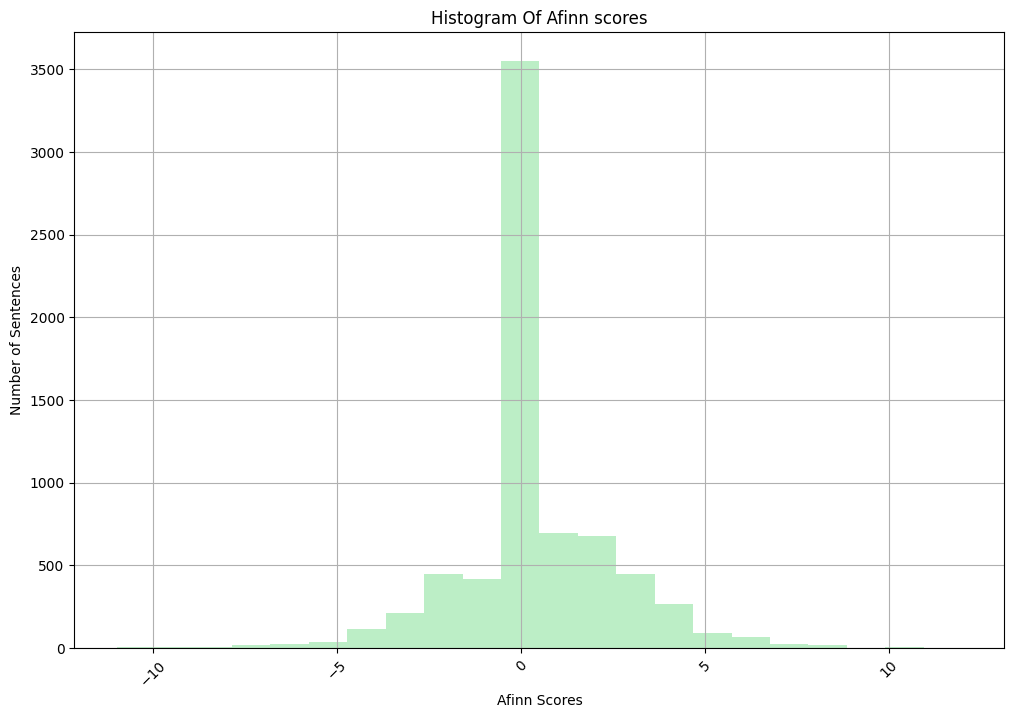

In [29]:
df.afinn.plot(kind='hist', #takes the column name as input
        alpha=0.7,
        bins = abs(min(df.afinn.value_counts().index.astype(int)) - max(df.afinn.value_counts().index.astype(int)))-1,
        title='Histogram Of Afinn scores',
        rot=45,
        grid=True,
        figsize=(12,8),
        fontsize=10,
        color=['#A0E8AF'])
plt.xlabel('Afinn Scores')
plt.ylabel("Number of Sentences");

In [30]:
#let's check the distribution of sentiment values

In [31]:
#@title
df.sentiment.value_counts() #df. column_name .value_counts()

,count
sentiment,
3,4245
4,1444
2,685
5,459
not_relevant,213
1,110


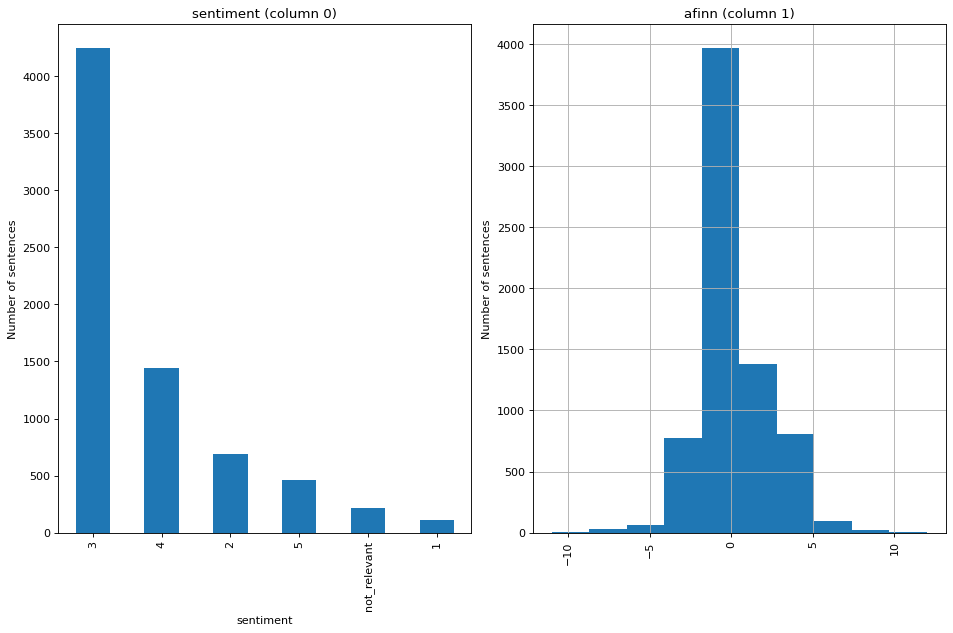

In [32]:
#we can compare the plots by using the function above
plotPerColumnDistribution(df,2,2)

Table that will indicate the value of sentiment what will corrispond to the prediction, in quantitive form. (Ground Truth respect to Prediction)

In [33]:
pd.crosstab(df.sentiment, df.afinn) #confusion matrix

afinn,-11.0,-10.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,...,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0
sentiment,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,1,4,5,2,13,16,12,...,6,5,1,0,2,0,0,0,0,0
2,0,1,2,4,7,7,10,32,55,113,...,67,36,20,6,6,1,2,0,1,0
3,0,0,0,1,3,4,15,38,85,215,...,335,173,86,30,12,9,5,0,2,0
4,1,0,0,1,3,7,10,23,39,88,...,192,152,91,38,26,7,10,1,1,0
5,0,0,1,0,1,0,0,5,14,14,...,57,67,57,16,18,6,5,1,1,2
not_relevant,0,0,1,0,1,2,2,4,2,9,...,24,17,12,4,4,2,0,0,0,1


**Suggestion:** take advantage of the Pandas cheat sheeet:

https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf



In [34]:
# Ignore tweets that are marked as 'not relevant'
df_relevant = df[df.sentiment != 'not_relevant'] #filter on rows
df_relevant['sentiment'] = df_relevant['sentiment'].astype(int) #control
df_relevant['afinn'] = df_relevant['afinn'].astype(int)

df_relevant[['sentiment', 'afinn', 'text']].head(10)

<ipython-input-34-e6aaf144543c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['sentiment'] = df_relevant['sentiment'].astype(int) #control
<ipython-input-34-e6aaf144543c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['afinn'] = df_relevant['afinn'].astype(int)


,sentiment,afinn,text
0,5,0,Two places I'd invest all my money if I could:...
1,5,5,Awesome! Google driverless cars will help the ...
2,2,1,If Google maps can't keep up with road constru...
3,2,0,Autonomous cars seem way overhyped given the t...
4,3,0,Just saw Google self-driving car on I-34. It w...
5,3,0,Will driverless cars eventually replace taxi d...
8,5,-3,Autonomous vehicles could reduce traffic fatal...
9,1,1,Driverless cars are not worth the risk. Don't...
10,3,1,"Driverless cars are now legal in Florida, Cali..."
11,3,0,Audi is the first carmaker to get a license fr...


In [35]:
#how can we compute a 3-class confusion matrix?
#positive (+1) neutral (0) negative (-1)

In [36]:
#@title
# Compute 3-class confusion matrix
confusion = pd.crosstab(np.sign(df_relevant.sentiment - 3),
                        np.sign(df_relevant.afinn))
confusion

afinn,-1,0,1
sentiment,,,
-1,355,210,230
0,601,2651,993
1,301,591,1011


In [37]:
#how do we compute the accuracy?

In [38]:
#@title
accuracy_3_class = np.sum(np.diag(confusion)) / np.sum(confusion.values)
accuracy_3_class

np.float64(0.5785683422151807)

In [39]:
#how can we compute a 2-class confusion matrix excluding neutral sentiments?

In [40]:
#@title
# Compute 2-class confusion matrix
confusion_2_class = confusion.iloc[[0, 2], [0, 2]] #beware!
confusion_2_class

afinn,-1,1
sentiment,,
-1,355,230
1,301,1011


How much is the accuracy?

In [41]:
#@title
accuracy_2_class = np.sum(np.diag(confusion_2_class)) / np.sum(confusion_2_class.values)
accuracy_2_class

np.float64(0.7200843437005798)

In [42]:
#How can we determine if our performance is good or bad?

ANSWER

Use as **baseline** the most frequent class.

In [43]:
accuracy_2_class_baseline = confusion_2_class.sum().max() / np.sum(confusion_2_class.values)
accuracy_2_class_baseline

np.float64(0.654190827622562)

There is an actual improvement w.r.t. to complete chance and to baseline

## Custom lexicon

You can also use a custom built lexicon.
You can enrich your own lexicon based on the application domain

In [45]:
import pandas as pd
# import the lexicon
lexicon_df = pd.read_excel("NRC-Emotion-Lexicon-v0.92-InManyLanguages-web.xlsx", engine="openpyxl")

#many languages
#8 emotion types
#https://github.com/sebastianruder/emotion_proposition_store/tree/master/NRC-Emotion-Lexicon-v0.92


#The NRC emotion lexicon is a list of words and their associations with
#eight emotions (anger, fear, anticipation, trust, surprise, sadness,
#joy, and disgust) and two sentiments (negative and positive). The
#annotations were manually done through Amazon's Mechanical Turk. Refer
#to publications below for more details: http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm


lexicon_df.head(10)

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,English Word,Arabic Translation (Google Translate),Basque Translation (Google Translate),Bengali Translation (Google Translate),Catalan Translation (Google Translate),Chinese (simplified) Translation (Google Translate),Chinese (traditional) Translation (Google Translate),Danish Translation (Google Translate),Dutch Translation (Google Translate),Esperanto Translation (Google Translate),...,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,aback,الى الوراء,aback,পশ্চাতে,darrere,吓了一跳,嚇了一跳,overrasket,verrast,surprizita,...,0,0,0,0,0,0,0,0,0,0
1,abacus,طبلية تاج,abako,গণনা-যন্ত্রবিশেষ,àbac,算盘,算盤,abacus,abacus,abako,...,0,0,0,0,0,0,0,0,0,1
2,abandon,تخلى,alde batera utzi,বর্জিত করা,abandonar,放弃,放棄,opgive,verlaten,forlasos,...,0,1,0,0,0,1,0,1,0,0
3,abandoned,مهجور,abandonatu,পরিত্যক্ত,abandonat,弃,棄,forladte,verlaten,forlasita,...,0,1,1,0,0,1,0,1,0,0
4,abandonment,هجر,abandono,বিসর্জন,abandonament,放弃,放棄,opgivelse,verlatenheid,forlasas,...,0,1,1,0,0,1,0,1,1,0
5,abate,انحسر,abate,প্রকোপ হ্রাস করা,disminuir,杀,殺,aftage,verminderen,Abate,...,0,0,0,0,0,0,0,0,0,0
6,abatement,انحسار,murrizteko,উপশম,disminució,减排,減排,nedskæring,vermindering,abatement,...,0,0,0,0,0,0,0,0,0,0
7,abba,أبا,abba,Abba,abba,ABBA,ABBA,abba,abba,ABBA,...,1,0,0,0,0,0,0,0,0,0
8,abbot,رئيس الدير,abade,মঠাধ্যক্ষ,abat,方丈,方丈,abbed,abt,abato,...,0,0,0,0,0,0,0,0,0,1
9,abbreviate,اختصر,laburtu,খাট করা,abreujar,简略,簡略,forkorte,afkorten,mallongigi,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# create a dict mapping word to value
lexicon = {}

#https://www.w3schools.com/python/ref_func_zip.asp

for word, pos, neg in zip(lexicon_df["English Word"], lexicon_df["Positive"], lexicon_df["Negative"]):
  if pos:
    value = 1
  elif neg:
    value = -1 #i do not consider 0's
  else:
    continue
  lexicon[str(word).lower()] = value #lower case

In [47]:
# this custom function will return the sentiment associated to a sentence via the sum of single words
def myscore(sentence):
  sentiment = 0
  for word in sentence.split(): #split function: divides the string from spaces
    sentiment += lexicon.get(word.lower()) if lexicon.get(word.lower()) is not None else 0 #+= operator
  return sentiment

In [48]:
# apply myscore function
df['myscore'] = df["text"].apply(myscore)
df[['sentiment', 'myscore', 'text']].tail(30)

,sentiment,myscore,text
7126,2,0,Creeps me out the the Google car does not have...
7127,1,0,I'd never trust a self-driving car to take my ...
7128,2,-1,Vehicles with no driver scare me. How could th...
7129,not_relevant,0,Audi to start testing in Tampa
7130,3,0,Ann Arbor Could Get Driverless Vehicles by 2021
7131,3,0,Saw the google car again today
7132,3,0,I wonder how insurance companies will handle a...
7133,3,2,Will police departments survive without speedi...
7134,3,0,I don't know what to think about self-driving ...
7135,3,1,Should Uber use driverless cars to ease safety...


In [49]:
#how do i compute a 2-class confusion matrix?

In [50]:
#@title
# Compute 2-class confusion matrix
df_relevant = df[df.sentiment != 'not_relevant']
df_relevant['sentiment'] = df_relevant['sentiment'].astype(int)
df_relevant['myscore'] = df_relevant['myscore'].astype(int)
confusion = pd.crosstab(np.sign(df_relevant.sentiment - 3), np.sign(df_relevant.myscore))
confusion_2_class = confusion.iloc[[0, 2], [0, 2]]
confusion_2_class

<ipython-input-50-0e117b07f14d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['sentiment'] = df_relevant['sentiment'].astype(int)
<ipython-input-50-0e117b07f14d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['myscore'] = df_relevant['myscore'].astype(int)


myscore,-1,1
sentiment,,
-1,182,206
1,245,648


In [51]:
#how do I compute the accuracy?

In [52]:
#@title
accuracy_2_class = np.sum(np.diag(confusion_2_class)) / np.sum(confusion_2_class.values)
accuracy_2_class

np.float64(0.6479313036690086)

In [53]:
#lower than the baseline! BEWARE

In [54]:
#what about the new and emerging lexicon?
#what about the lexicon of 5 years ago?
#what about the automated translation?
#what about the conjugations? variations?

## Textual Preprocessing

**NLTK** is one of the leading platforms for working with human language data and Python, the module NLTK is used for natural language processing. NLTK is literally an acronym for Natural Language Toolkit.

The first common step in NLP (Natural Language Processing) is **tokenization**.

*Tokens* are usually individual words (at least in languages like English) and *tokenization* is taking a text or set of text and breaking it up into its individual words.

**These tokens are then used as the input for other types of analysis or tasks.**

In [55]:
#word_tokenize function
import nltk
nltk.download('punkt_tab')

print(tweets.iloc[20])
print(word_tokenize(tweets.iloc[20]))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...


Today state regs for autonomous cars go into effect: Audi of America gets 1st permit to test driverless cars on public roads, per @CA_DMV.
['Today', 'state', 'regs', 'for', 'autonomous', 'cars', 'go', 'into', 'effect', ':', 'Audi', 'of', 'America', 'gets', '1st', 'permit', 'to', 'test', 'driverless', 'cars', 'on', 'public', 'roads', ',', 'per', '@', 'CA_DMV', '.']


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [56]:
#what about @?

When dealing with social media text, we usually want to identify urls, hashtags, smileys as separate objects and do not tokenize it to individual characters.

In [57]:
#regular expression - regex: (sub)strings that we try to match with the text

In [58]:
import re

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    return tokens_re.findall(s)

def preprocess(s, lowercase=False): #custom function
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [59]:
#let's find out how it works

In [60]:
print('Original sentence:')
print(tweets.iloc[9])
print()

print('Sentence after tokenization')
print(word_tokenize(tweets.iloc[9]))
print()

print('Sentence after tokenization with regex preprocessing')
print(preprocess(tweets.iloc[9]))

Original sentence:
Driverless cars are not worth the risk.  Don't want to be on the highway when the server crashes #SadMacFace #BlueScreenofDeath

Sentence after tokenization
['Driverless', 'cars', 'are', 'not', 'worth', 'the', 'risk', '.', 'Do', "n't", 'want', 'to', 'be', 'on', 'the', 'highway', 'when', 'the', 'server', 'crashes', '#', 'SadMacFace', '#', 'BlueScreenofDeath']

Sentence after tokenization with regex preprocessing
['Driverless', 'cars', 'are', 'not', 'worth', 'the', 'risk', '.', "Don't", 'want', 'to', 'be', 'on', 'the', 'highway', 'when', 'the', 'server', 'crashes', '#SadMacFace', '#BlueScreenofDeath']


In [61]:
#what about don't'?  what about hashtags? mentions?

How can we apply a function to all element in a series?

In [62]:
tweets.apply(preprocess) #we haven't altered the series, we won't used our regex-based preprocesing

,text
0,"[Two, places, I'd, invest, all, my, money, if,..."
1,"[Awesome, !, Google, driverless, cars, will, h..."
2,"[If, Google, maps, can't, keep, up, with, road..."
3,"[Autonomous, cars, seem, way, overhyped, given..."
4,"[Just, saw, Google, self-driving, car, on, I, ..."
...,...
7151,"[Washington, DC, metro, trains, are, all, self..."
7152,"[I, think, #DARPA, works, on, autonomous, dron..."
7153,"[I, love, the, idea, of, driving, myself, to, ..."
7154,"[Who, likes, cars, these, days, ?, No, me, ., ..."


In [63]:
#check lambda functions in python
#https://realpython.com/python-lambda/

tweets = tweets.apply(lambda x: x.lower())
#to set in lowercase is important

In [64]:
print(tweets)

0       two places i'd invest all my money if i could:...
1       awesome! google driverless cars will help the ...
2       if google maps can't keep up with road constru...
3       autonomous cars seem way overhyped given the t...
4       just saw google self-driving car on i-34. it w...
                              ...                        
7151    washington dc metro trains are all self-drivin...
7152    i think #darpa works on autonomous drone techn...
7153    i love the idea of driving myself to the denti...
7154    who likes cars these days? no me. too expensiv...
7155    my dream car is a pink cadillac. i'd also need...
Name: text, Length: 7156, dtype: object


Nltk released the **Twitter-aware tokenizer**, which is designed ad-hoc for dealing with Twitter posts.

In this way, we can avoid using arbitrary regex

In [65]:
from nltk.tokenize import TweetTokenizer
tokening = TweetTokenizer()

s0 = "@remy This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
print("Twitter tokenizer -> ", tokening.tokenize(s0))
print("Preprocess function -> ", preprocess(s0))

Twitter tokenizer ->  ['@remy', 'This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3', 'and', 'some', 'arrows', '<', '>', '->', '<--']
Preprocess function ->  ['@remy', 'This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3 and some arrows < >', '-', '>', '<', '-', '-']


In [66]:
tokening = TweetTokenizer(strip_handles=True, reduce_len=True)
#remember to check the parameters!
#strip_handles: removes the citations
#reduce_len: reduces the length of words containing too many repeated letters
#(in this case more than 3 repeated letters)

s1 = '@remy: This is waaaaayyyy too much for youuuuuu!!!!!! #love'
print("Twitter tokenizer -> ",tokening.tokenize(s1))

Twitter tokenizer ->  [':', 'This', 'is', 'waaayyy', 'too', 'much', 'for', 'youuu', '!', '!', '!', '#love']


Let's apply this tokenizer to our dataset.

In [67]:
tweets_tokenized = tweets.apply(TweetTokenizer().tokenize)
tweets_tokenized

,text
0,"[two, places, i'd, invest, all, my, money, if,..."
1,"[awesome, !, google, driverless, cars, will, h..."
2,"[if, google, maps, can't, keep, up, with, road..."
3,"[autonomous, cars, seem, way, overhyped, given..."
4,"[just, saw, google, self-driving, car, on, i, ..."
...,...
7151,"[washington, dc, metro, trains, are, all, self..."
7152,"[i, think, #darpa, works, on, autonomous, dron..."
7153,"[i, love, the, idea, of, driving, myself, to, ..."
7154,"[who, likes, cars, these, days, ?, no, me, ., ..."


#*Are we good? is the dataset sufficiently pre-processed?*

Let's count the **frequency** of each word in the dataset.

In [68]:
from collections import Counter

# list all of words
flat_list = [item for sublist in tweets_tokenized for item in sublist]
flat_list

['two',
 'places',
 "i'd",
 'invest',
 'all',
 'my',
 'money',
 'if',
 'i',
 'could',
 ':',
 '3d',
 'printing',
 'and',
 'self-driving',
 'cars',
 '!',
 '!',
 '!',
 'awesome',
 '!',
 'google',
 'driverless',
 'cars',
 'will',
 'help',
 'the',
 'blind',
 'travel',
 'more',
 'often',
 ';',
 'https://t.co/qwuxr0frbpv',
 'if',
 'google',
 'maps',
 "can't",
 'keep',
 'up',
 'with',
 'road',
 'construction',
 ',',
 'how',
 'am',
 'i',
 'supposed',
 'to',
 'trust',
 'a',
 'driverless',
 'car',
 'to',
 'get',
 'around',
 'here',
 '?',
 'autonomous',
 'cars',
 'seem',
 'way',
 'overhyped',
 'given',
 'the',
 'technology',
 'challenges',
 ';',
 'pilotless',
 'planes',
 'seem',
 'much',
 'more',
 'doable',
 'and',
 'needed',
 '.',
 'just',
 'saw',
 'google',
 'self-driving',
 'car',
 'on',
 'i',
 '-',
 '34',
 '.',
 'it',
 'was',
 'painted',
 'green',
 'and',
 'blue',
 '.',
 'will',
 'driverless',
 'cars',
 'eventually',
 'replace',
 'taxi',
 'drivers',
 'in',
 'cities',
 '?',
 'chicago',
 'metro'

Let's print the most common tokens. Everything fine?

In [69]:
c = Counter(flat_list) #let's merge anything in a single list
c.most_common(10)

[('.', 4643),
 ('car', 3756),
 ('the', 3539),
 ('cars', 3203),
 ('self-driving', 2519),
 ('a', 2437),
 ('\x89', 2324),
 ('google', 2232),
 (',', 2218),
 ('to', 2193)]

In [70]:
# Function to get the counter (will be helpful later on)
def get_counter(series):
  flat_list = [item for sublist in series for item in sublist]
  c = Counter(flat_list)
  return c

## Stopwords removal

One of the major forms of pre-processing is to filter out *useless* data.

In natural language processing, useless words (data), are referred to as **stopwords**.

A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that should be ignored.

In [71]:
from nltk.corpus import stopwords
stop = stopwords.words('english') #important!
stop

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

Are we sure we want to use all the default stopwords?

In [72]:
#what about negations? what about other lists?

In [73]:
stop = [item for item in stop if item not in ["not", "nor", "against"]]

In [74]:
tweets_tokenized_stop = tweets_tokenized.apply(lambda x: [item for item in x if item not in stop])
tweets_tokenized_stop

,text
0,"[two, places, invest, money, could, :, 3d, pri..."
1,"[awesome, !, google, driverless, cars, help, b..."
2,"[google, maps, can't, keep, road, construction..."
3,"[autonomous, cars, seem, way, overhyped, given..."
4,"[saw, google, self-driving, car, -, 34, ., pai..."
...,...
7151,"[washington, dc, metro, trains, self-driving, ..."
7152,"[think, #darpa, works, autonomous, drone, tech..."
7153,"[love, idea, driving, dentist, ., get, license..."
7154,"[likes, cars, days, ?, ., expensive, ., need, ..."


Let's **print** the 10 most common tokens. Everything fine?

In [75]:
get_counter(tweets_tokenized_stop).most_common(10)

[('.', 4643),
 ('car', 3756),
 ('cars', 3203),
 ('self-driving', 2519),
 ('\x89', 2324),
 ('google', 2232),
 (',', 2218),
 (':', 2093),
 ('˘', 1831),
 ('driverless', 1819)]

## Punctuation Removal



In [76]:
import string
from nltk import wordpunct_tokenize

punctuation = string.punctuation #string library
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [77]:
#how can we remove the punctuation?

In [78]:
tweets_tokenized_stop_punct = tweets_tokenized_stop.apply(lambda x: [item for item in x if item not in punctuation])
tweets_tokenized_stop_punct

,text
0,"[two, places, invest, money, could, 3d, printi..."
1,"[awesome, google, driverless, cars, help, blin..."
2,"[google, maps, can't, keep, road, construction..."
3,"[autonomous, cars, seem, way, overhyped, given..."
4,"[saw, google, self-driving, car, 34, painted, ..."
...,...
7151,"[washington, dc, metro, trains, self-driving, ..."
7152,"[think, #darpa, works, autonomous, drone, tech..."
7153,"[love, idea, driving, dentist, get, license, n..."
7154,"[likes, cars, days, expensive, need, drive, an..."


Let's **print** the 10 most common tokens. Everything fine?

In [79]:
get_counter(tweets_tokenized_stop_punct).most_common(10)

[('car', 3756),
 ('cars', 3203),
 ('self-driving', 2519),
 ('\x89', 2324),
 ('google', 2232),
 ('˘', 1831),
 ('driverless', 1819),
 ('driving', 1743),
 ('self', 1481),
 ('ââ', 1048)]

Adding a few more stop words after getting the distinct words.

In [80]:
#explore the dataset and generate a list to be filtered

In [81]:
stop = set(stop)
#adding some of the stopwords after observing the tweets
stop.add("The")
stop.add("And")
stop.add("I")
stop.add("J")
stop.add("K")
stop.add("I'd")
stop.add("That's")
stop.add("\x81")
stop.add("It")
stop.add("I'm")
stop.add("...")
stop.add("\x89")
stop.add("ĚĄ")
stop.add("it's")
stop.add("ă")
stop.add("\x9d")
stop.add("âÂĺ")
stop.add("Ě")
stop.add("˘")
stop.add("Â")
stop.add("âÂ")
stop.add("Ň")
stop.add("http")
stop.add("https")
stop.add("co")
stop.add("000")
stop.add("Ň")
stop.add("Ň")
stop.add("Ň")
stop.add("ââ")
stop.add('ě')
stop.add('ň')

stop = list(stop)
print(stop)

tweets_tokenized_stop_punct = tweets_tokenized_stop_punct.apply(lambda x: [item for item in x if item not in stop])
tweets_tokenized_stop_punct

['whom', 'when', 'do', 'mightn', 'she', 'won', 'same', 'mustn', 'very', 'J', 'so', "didn't", "doesn't", 'her', 'The', "aren't", 'I', 'most', 'out', 'or', 'its', 'below', 'm', 'over', 'down', 'being', "should've", 've', 'both', 'we', 'doing', 'above', 'is', 'through', 'ň', 'it', 'any', 'them', 'ă', 'because', 're', 'why', '\x89', 'K', 'can', 'you', 'a', 'more', 'weren', 'than', 'ain', 'are', 'at', 'own', 'too', 'ââ', 'me', "they'd", 'there', "weren't", 'all', 'http', 'my', 'into', 'that', 'an', 'further', 'having', 'with', 'isn', 'after', "you'd", "i'm", 'until', 'while', 'your', "she'll", "couldn't", "hasn't", 'this', 'he', 'themselves', 'ĚĄ', "they've", 'itself', 'our', 'haven', "needn't", 'd', 'off', 'https', 'then', 'what', '\x9d', "won't", 'myself', 'had', 'by', 'has', 'âÂ', 'aren', 'hers', 'did', "haven't", 'was', 'yourselves', 'they', 'It', 'hasn', "you've", 'And', '000', "mightn't", 'again', "we're", 'yourself', 'don', "shan't", '˘', "they're", 'those', 'shan', 'just', "she's", 

,text
0,"[two, places, invest, money, could, 3d, printi..."
1,"[awesome, google, driverless, cars, help, blin..."
2,"[google, maps, can't, keep, road, construction..."
3,"[autonomous, cars, seem, way, overhyped, given..."
4,"[saw, google, self-driving, car, 34, painted, ..."
...,...
7151,"[washington, dc, metro, trains, self-driving, ..."
7152,"[think, #darpa, works, autonomous, drone, tech..."
7153,"[love, idea, driving, dentist, get, license, n..."
7154,"[likes, cars, days, expensive, need, drive, an..."


Let's **print** the 10 most common tokens. Everything fine?

In [82]:
get_counter(tweets_tokenized_stop_punct).most_common(10)

[('car', 3756),
 ('cars', 3203),
 ('self-driving', 2519),
 ('google', 2232),
 ('driverless', 1819),
 ('driving', 1743),
 ('self', 1481),
 ("google's", 469),
 ('autonomous', 370),
 ('saw', 312)]

## Stemming

Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form.

In [83]:
from nltk.stem.lancaster import LancasterStemmer
#there are many stemmer in NLTK

lancaster_stemmer = LancasterStemmer()

In [84]:
nltk.word_tokenize("I was working when a car drove into the place".lower())

['i', 'was', 'working', 'when', 'a', 'car', 'drove', 'into', 'the', 'place']

In [85]:
#the stemmer required tokenized sentence
[lancaster_stemmer.stem(item) for item in nltk.word_tokenize("I was working when a car drove into the place".lower())]

['i', 'was', 'work', 'when', 'a', 'car', 'drov', 'into', 'the', 'plac']

In [86]:
#beware of overstemming!

In [87]:
tweets_tokenized_new_stem = tweets_tokenized_stop_punct.apply(lambda x: [lancaster_stemmer.stem(item) for item in x])
tweets_tokenized_new_stem

,text
0,"[two, plac, invest, money, could, 3d, print, s..."
1,"[awesom, googl, driverless, car, help, blind, ..."
2,"[googl, map, can't, keep, road, construct, sup..."
3,"[autonom, car, seem, way, overhyp, giv, techno..."
4,"[saw, googl, self-driving, car, 34, paint, gre..."
...,...
7151,"[washington, dc, metro, train, self-driving, ar]"
7152,"[think, #darpa, work, autonom, dron, technolog..."
7153,"[lov, ide, driv, dent, get, licens, next, mon,..."
7154,"[lik, car, day, expend, nee, driv, anywh]"


Let's **print** the 10 most common tokens.

In [88]:
#what do we expect about car?

In [89]:
#@title
get_counter(tweets_tokenized_new_stem).most_common(10)

[('car', 6978),
 ('self-driving', 2519),
 ('driv', 2326),
 ('googl', 2252),
 ('driverless', 1819),
 ('self', 1481),
 ("google's", 469),
 ('autonom', 374),
 ('vehic', 370),
 ('get', 353)]

Can you think about any problems that this process can introduce?

## Visualize words

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
from PIL import Image
import numpy as np

from wordcloud import WordCloud

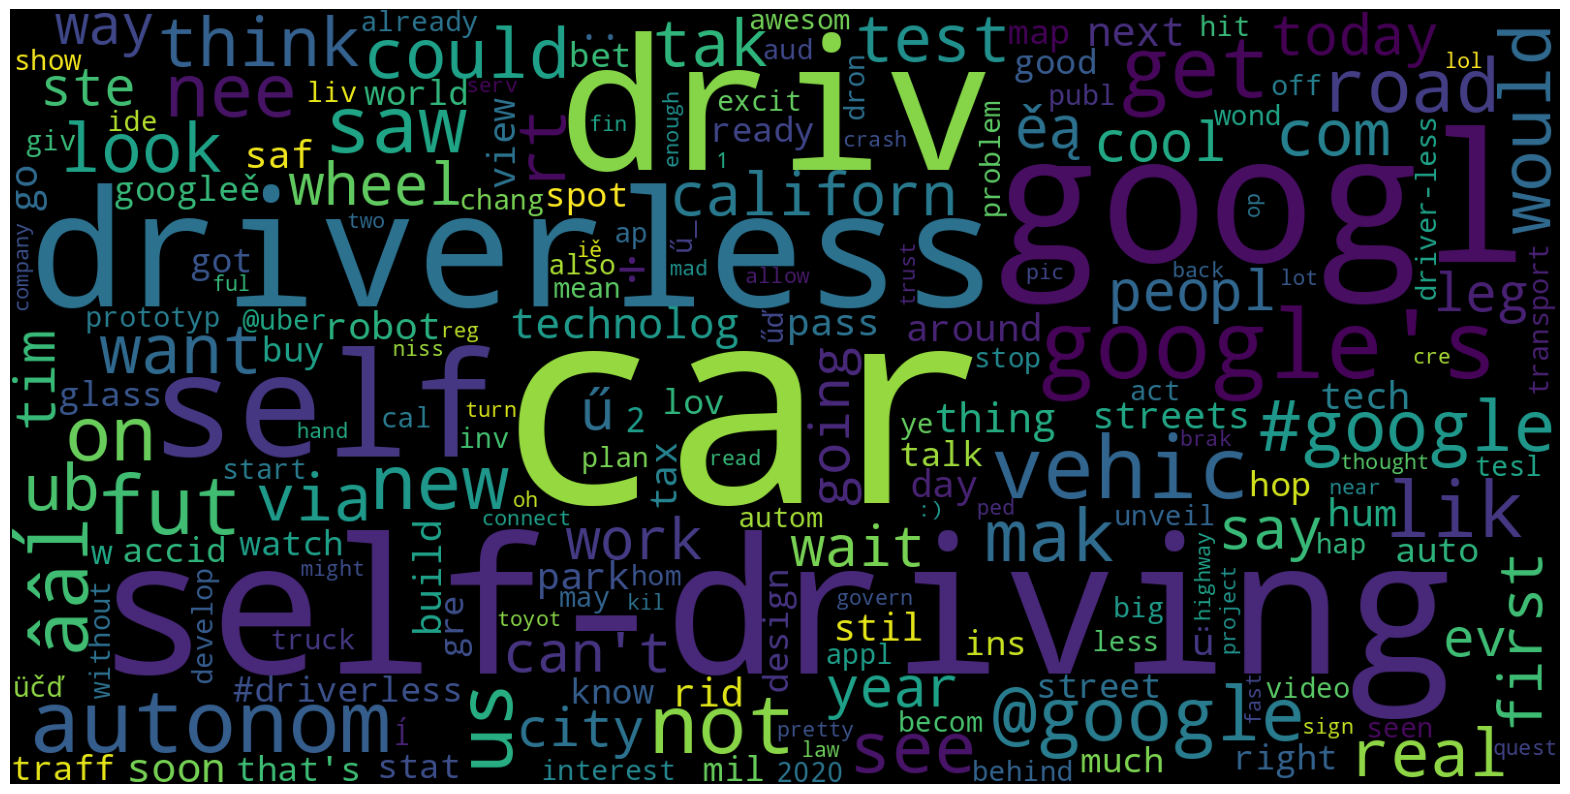

In [92]:
flat_list = [item for sublist in tweets_tokenized_new_stem for item in sublist] #unique list containing all tokens

fig = plt.figure(figsize=(20,14))
wordcloud = WordCloud(width=1600, height=800, background_color="black").generate_from_frequencies(Counter(flat_list))
plt.axis("off")
plt.imshow(wordcloud, interpolation='antialiased')

In [93]:
#did you spot anything strange?

In [94]:
# We could also use wordnet to aggregate same concept words
# https://www.nltk.org/api/nltk.corpus.reader.wordnet.html

from nltk.corpus import wordnet
nltk.download('wordnet')

for syn in wordnet.synsets("car"):
  for lemma in syn.lemmas():
    print(lemma.name())

[nltk_data] Downloading package wordnet to /root/nltk_data...


car
auto
automobile
machine
motorcar
car
railcar
railway_car
railroad_car
car
gondola
car
elevator_car
cable_car
car


In [95]:
#what about the wordcloud now?
#homework!

## Supervised Machine Learning approach
To perform supervised Sentiment Analysis, we should use supervised machine learning models. **Scikit-learn** is a Python module with built-in machine learning algorithms.

First, texual attributes should be converted to a numerical representation, e.g., **bag-of-word representation**.

*Rows: documents*

*Columns: token*

The integer value *n* returns how many time the specific token is found in the document.

**In our case we know the ground-truth sentiment, that can be employed to train the ML method and evaluate its performance.**

In [96]:
# It is possible to specify different parameters, e.g. stopwords, lowercase
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words=None, lowercase=True, max_features=5000)
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#stopwords were already removed in tweets_tokenized_new_stem

#to create the bag of words (bow)
#fit_transform takes as input  full sententeces NOT token
#so, the join function combines sparated tokens including spaces " "
bow = count_vect.fit_transform(tweets_tokenized_new_stem.apply(lambda x: " ".join(x)))

#fit and transform functions can be separated

print(len(tweets_tokenized_new_stem))
print(bow.shape)
print(bow.toarray())

7156
(7156, 5000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In order to perform a machine learning task, we split the training data to get an evaluation set through Scikit-learn’s built-in **model_selection** function.

All we need to do is provide the data and assign a training percentage.

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(
        bow.toarray(),
        df.sentiment,
        train_size=0.80,
        random_state=1234)

Which is the size of training and test data?

In [98]:
print(len(X_train), len(X_test))

5724 1432


## Linear Classifier
We can now build the classifier for this dataset. We will be using the **LogisticRegression** class from Scikit-learn.

In [99]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter = 250)

Once the model is initialized, we have to train it to our specific dataset, so we use Scikit-learn’s **fit** method to do so.

This is where our machine learning classifier actually learns the underlying functions that produce our results.

In [100]:
log_model = log_model.fit(X=X_train, y=y_train)

And finally, we use log_model to label the test set we created earlier.

In [101]:
y_pred = log_model.predict(X_test)
print(y_pred)

['3' '4' '4' ... '3' '4' '4']


## Performance measures

The **sklearn.metrics** module implements functions assessing prediction error for specific purposes. These metrics are detailed in sections on Classification metrics, Multilabel ranking metrics, Regression metrics and Clustering metrics.

Since we are dealing with a classification problem, we are interested on Accuracy, Precision, Recall and F-measure

![alt text](https://cdn-images-1.medium.com/max/1600/1*pOtBHai4jFd-ujaNXPilRg.png)

In [102]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.63268156424581


In [103]:
#what can you say? why so low?

In [104]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[  2   6  10   4   0   1]
 [  0  22  85  17   3   0]
 [  1  18 754  67   7   8]
 [  2  12 160 102  14   3]
 [  0   0  37  32  20   0]
 [  0   3  27   9   0   6]]


In [105]:
#plot the confusion matrix!

<Axes: >

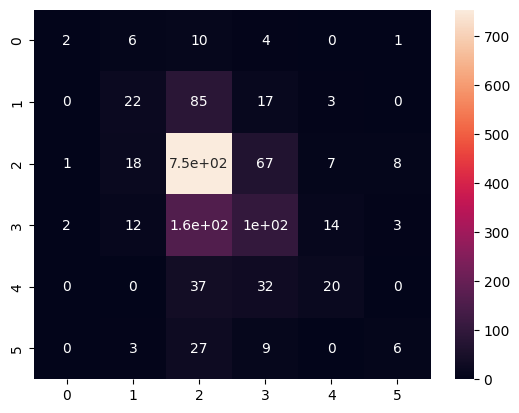

In [106]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

The support is the number of occurrences of each class in y_true.

In [107]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.40      0.09      0.14        23
           2       0.36      0.17      0.23       127
           3       0.70      0.88      0.78       855
           4       0.44      0.35      0.39       293
           5       0.45      0.22      0.30        89
not_relevant       0.33      0.13      0.19        45

    accuracy                           0.63      1432
   macro avg       0.45      0.31      0.34      1432
weighted avg       0.59      0.63      0.59      1432



Why the weighted results are higher?


## Cross-validation

Cross-validation is any of various similar model validation techniques for assessing how the results of a statistical analysis will generalize to an independent data set.

![alt text](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg)

In [108]:
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(max_iter = 250)
scores = cross_val_score(clf, bow.toarray(), df.sentiment, cv=3)

In [109]:
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.60352054 0.55849057 0.6033543 ]
Accuracy: 0.59 (+/- 0.04)


In [110]:
from sklearn.model_selection import cross_validate
scoring = ['precision_macro', 'recall_macro']
clf = LogisticRegression(max_iter = 250)
scores = cross_validate(clf, bow.toarray(), df.sentiment, scoring=scoring,
                        cv=3, return_train_score=False)


In [111]:
print(sorted(scores.keys()))
scores['test_precision_macro']

['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']


array([0.35120729, 0.48024254, 0.37394428])

# Assignment

Take the **TRUMP** tweets and create your analytics:


*   When Trump wishes the Olympic team good luck, he’s tweeting
from his iPhone.
*   When he’s insulting a rival, he’s usually tweeting from an Android.

Make your analytics!

*Is this an artifact showing which tweets are Trump’s own and which
are by some handler? Any other insights?*

### Hint

Control for instance:
* Number of tweets from Android/iPhone
* Most frequent positive and words
* Sentiment dynamics






In [4]:
url = 'https://raw.githubusercontent.com/nprapps/trump-tweet-analysis/master/data/since-20170120.json'
trump_df = pd.read_json(url)

In [5]:
print(trump_df.head(5))
print(trump_df.columns)

               source                                               text  \
0  Twitter for iPhone  Still can’t believe that Bloomberg violated a ...   
1  Twitter for iPhone  Great day in North Carolina where Republicans ...   
2  Twitter for iPhone  The ABC/Washington Post Poll was by far the le...   
3  Twitter for iPhone  .@Rasmussen_Poll just came out at 48% approval...   
4  Twitter for iPhone                            https://t.co/c79zLeREOA   

                 created_at  retweet_count  favorite_count  is_retweet  \
0 2018-09-01 02:40:23+00:00           5540           21996       False   
1 2018-09-01 02:36:57+00:00           3885           18946       False   
2 2018-09-01 02:35:28+00:00           5164           20129       False   
3 2018-09-01 02:25:38+00:00           5717           21855       False   
4 2018-09-01 00:01:21+00:00           8506           31907       False   

                id_str  
0  1035718986871320576  
1  1035718119459893248  
2  1035717747936768000 

Source: platform or device where the tweets are shared.

Text: content of the tweets

created_at: the day and the hour

retweet_count: number of retweet

favorite_count: number of like

is_retweet: if the tweet is retweeted from another person.

id_strg

In [6]:
print(trump_df.columns)

Index(['source', 'text', 'created_at', 'retweet_count', 'favorite_count',
       'is_retweet', 'id_str'],
      dtype='object')


### First step : Number of tweets from Android and Iphone

According to various online sources, the device or platform used to publish a tweet from Donald Trump's account may offer clues about its author. Tweets posted via Twitter for iPhone are often believed to have been written personally by Trump himself. In contrast, those sent from Twitter for Android were likely composed by members of his staff, particularly before 2017. Tweets published through Media Studio are generally associated with staff activity, often involving scheduled posts, videos, or official campaign content. When the Twitter Web Client is listed as the source, it indicates the tweet was made using a web browser, likely from a computer or laptop. Other platforms, such as Twitter for iPad or Twitter Ads, suggest alternative publishing methods, like tablet use or promoted content managed by his digital team.

In [7]:
print(trump_df['source'].unique())
print(trump_df['source'].value_counts())

['Twitter for iPhone' 'Media Studio' 'Twitter Web Client'
 'Twitter for iPad' 'Twitter Ads' 'Twitter for Android']
source
Twitter for iPhone     4134
Twitter for Android     174
Media Studio            153
Twitter Web Client       45
Twitter for iPad         36
Twitter Ads              33
Name: count, dtype: int64


### Second Step : Most frequent positive and Words

This section aims to verify the validity of these assumptions by analyzing the most common words used in tweets sent from iPhone and Android platforms.

In the previous chapter for the attributes of our dataset there is the attribute 'is_retweet', and we want to know if there is discrepancy between Trump's writing from iPhone and Android, then we want to remove the retweteed post.

In [8]:
trum_df_without_retweet = trump_df[trump_df['is_retweet'] == False]

In [9]:
print("Tweet totali: ", len(trum_df_without_retweet))
print("Tweet originali: ", len(trump_df))
print("Retweet rimossi: ", len(trump_df) - len(trum_df_without_retweet))
trum_df_without_retweet.head(10)

Tweet totali:  4042
Tweet originali:  4575
Retweet rimossi:  533


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,Still can’t believe that Bloomberg violated a ...,2018-09-01 02:40:23+00:00,5540,21996,False,1035718986871320576
1,Twitter for iPhone,Great day in North Carolina where Republicans ...,2018-09-01 02:36:57+00:00,3885,18946,False,1035718119459893248
2,Twitter for iPhone,The ABC/Washington Post Poll was by far the le...,2018-09-01 02:35:28+00:00,5164,20129,False,1035717747936768000
3,Twitter for iPhone,.@Rasmussen_Poll just came out at 48% approval...,2018-09-01 02:25:38+00:00,5717,21855,False,1035715271418413056
4,Twitter for iPhone,https://t.co/c79zLeREOA,2018-09-01 00:01:21+00:00,8506,31907,False,1035678961349668864
5,Twitter for iPhone,“President Donald J. Trump is Strengthening Re...,2018-08-31 22:07:25+00:00,9169,34220,False,1035650292782653440
6,Twitter for iPhone,"Wow, I made OFF THE RECORD COMMENTS to Bloombe...",2018-08-31 18:37:04+00:00,21059,86847,False,1035597354395680768
7,Twitter for iPhone,I will be doing a major rally for Senator Ted ...,2018-08-31 17:09:01+00:00,25693,91425,False,1035575198169411584
8,Twitter for iPhone,"Thank you Indiana, I love you!\nhttps://t.co/T...",2018-08-31 01:50:40+00:00,18807,76891,False,1035344085798801408
9,Media Studio,Throwback Thursday! #MAGA https://t.co/8slzITa1l6,2018-08-30 19:59:32+00:00,25370,88927,False,1035255721951035392


In [10]:
from nltk.tokenize import TweetTokenizer
tokening = TweetTokenizer()

tweets_trump = trum_df_without_retweet.text
tweets_trump = tweets_trump.apply(lambda x: x.lower())
tokening = TweetTokenizer(strip_handles=True, reduce_len=True)

tweets_tokenized = tweets_trump.apply(tokening.tokenize)
for tokens in tweets_tokenized:
    print(tokens)

['still', 'can', '’', 't', 'believe', 'that', 'bloomberg', 'violated', 'a', 'firm', 'off', 'the', 'record', 'statement', '.', 'will', 'they', 'put', 'out', 'an', 'apology', '?']
['great', 'day', 'in', 'north', 'carolina', 'where', 'republicans', 'will', 'do', 'very', 'well', '!']
['the', 'abc', '/', 'washington', 'post', 'poll', 'was', 'by', 'far', 'the', 'least', 'accurate', 'one', '2', 'weeks', 'out', 'from', 'the', '2016', 'election', '.', 'i', 'call', 'it', 'a', 'suppression', 'poll', '-', 'but', 'by', 'election', 'day', 'they', 'brought', 'us', ',', 'out', 'of', 'shame', ',', 'to', 'about', 'even', '.', 'they', 'will', 'never', 'learn', '!']
['.', 'just', 'came', 'out', 'at', '48', '%', 'approval', 'rate', 'despite', 'the', 'constant', 'and', 'intense', 'fake', 'news', '.', 'higher', 'than', 'election', 'day', 'and', 'higher', 'than', 'president', 'obama', '.', 'rasmussen', 'was', 'one', 'of', 'the', 'most', 'accurate', 'election', 'day', 'polls', '!']
['https://t.co/c79zlereoa']


As we can observe, the most frequent tokens are punctuation marks and common words such as ".", ",", "the", "!", "a", and "of". These tokens do not provide meaningful insights for our analysis. Therefore, it is necessary to remove stopwords and focus on retaining informative words that contribute to understanding the content, rather than eliminating them in the preprocessing phase.

In [14]:
from collections import Counter

# Function to get the counter (will be helpful later on)
def get_counter(series):
  flat_list = [item for sublist in series for item in sublist]
  c = Counter(flat_list)
  return c

In [15]:
get_counter(tweets_tokenized).most_common(10)

[('.', 5781),
 ('the', 5332),
 (',', 4947),
 ('to', 3017),
 ('!', 3000),
 ('and', 2958),
 ('of', 2276),
 ('a', 1933),
 ('in', 1633),
 ('is', 1599)]

In [18]:
from nltk.corpus import stopwords
stop = stopwords.words('english') #important!

stop = [item for item in stop if item not in ["not", "nor", "against"]]
stop

['a',
 'about',
 'above',
 'after',
 'again',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our'

In [19]:
tweets_tokenized_stop = tweets_tokenized.apply(lambda x: [item for item in x if item not in stop])
tweets_tokenized_stop

,text
0,"[still, ’, believe, bloomberg, violated, firm,..."
1,"[great, day, north, carolina, republicans, wel..."
2,"[abc, /, washington, post, poll, far, least, a..."
3,"[., came, 48, %, approval, rate, despite, cons..."
4,[https://t.co/c79zlereoa]
...,...
4570,"[january, 20th, 2017, ,, remembered, day, peop..."
4571,"[truly, matters, not, party, controls, governm..."
4572,"[power, washington, ,, ., c, ., giving, back, ..."
4573,"[today, not, merely, transferring, power, one,..."


As we can see, punctuation will still be present.

In [20]:
get_counter(tweets_tokenized_stop).most_common(10)

[('.', 5781),
 (',', 4947),
 ('!', 3000),
 ('great', 987),
 ('&', 718),
 ('’', 698),
 ('...', 678),
 ('-', 497),
 ('not', 459),
 ('people', 447)]

In [21]:
import string
from nltk import wordpunct_tokenize

punctuation = string.punctuation #string library
print(punctuation)
tweets_tokenized_stop_punct = tweets_tokenized_stop.apply(lambda x: [item for item in x if item not in punctuation])
tweets_tokenized_stop_punct

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


,text
0,"[still, ’, believe, bloomberg, violated, firm,..."
1,"[great, day, north, carolina, republicans, well]"
2,"[abc, washington, post, poll, far, least, accu..."
3,"[came, 48, approval, rate, despite, constant, ..."
4,[https://t.co/c79zlereoa]
...,...
4570,"[january, 20th, 2017, remembered, day, people,..."
4571,"[truly, matters, not, party, controls, governm..."
4572,"[power, washington, c, giving, back, american,..."
4573,"[today, not, merely, transferring, power, one,..."


In [22]:
get_counter(tweets_tokenized_stop_punct).most_common(10)

[('great', 987),
 ('’', 698),
 ('...', 678),
 ('not', 459),
 ('people', 447),
 ('“', 419),
 ('”', 419),
 ('news', 366),
 ('fake', 331),
 ('big', 327)]

In [25]:
stop = set(stop)
#adding some of the stopwords after observing the tweets
stop.add("...")
stop.add("“")
stop.add("”")
stop.add("’")

stop = list(stop)

tweets_tokenized_stop_punct = tweets_tokenized_stop_punct.apply(lambda x: [item for item in x if item not in stop])
get_counter(tweets_tokenized_stop_punct).most_common(10)

[('great', 987),
 ('not', 459),
 ('people', 447),
 ('news', 366),
 ('fake', 331),
 ('big', 327),
 ('u', 322),
 ('country', 322),
 ('many', 289),
 ('president', 281)]

Now we can try to use the Stemming, because it could use synonimis of the same word, and we don't need the gender of the words(Maybe it will change the name of some person)

In [26]:
from nltk.stem.lancaster import LancasterStemmer
#there are many stemmer in NLTK

lancaster_stemmer = LancasterStemmer()

tweets_tokenized_new_stem = tweets_tokenized_stop_punct.apply(lambda x: [lancaster_stemmer.stem(item) for item in x])
get_counter(tweets_tokenized_new_stem).most_common(10)

[('gre', 1017),
 ('new', 548),
 ('not', 474),
 ('peopl', 448),
 ('country', 394),
 ('stat', 348),
 ('big', 343),
 ('fak', 332),
 ('job', 330),
 ('presid', 328)]

In the first sentence can't disappeared this is not good for the interpretability of the phrase.

In [27]:
tweets_tokenized_new_stem

,text
0,"[stil, believ, bloomberg, viol, firm, record, ..."
1,"[gre, day, nor, carolin, republ, wel]"
2,"[abc, washington, post, pol, far, least, acc, ..."
3,"[cam, 48, approv, rat, despit, const, intens, ..."
4,[https://t.co/c79zlereoa]
...,...
4570,"[janu, 20th, 2017, rememb, day, peopl, becam, ..."
4571,"[tru, mat, not, party, control, govern, wheth,..."
4572,"[pow, washington, c, giv, back, am, peopl, #in..."
4573,"[today, not, mer, transfer, pow, on, admin, an..."


In [28]:
trum_df_without_retweet

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,Still can’t believe that Bloomberg violated a ...,2018-09-01 02:40:23+00:00,5540,21996,False,1035718986871320576
1,Twitter for iPhone,Great day in North Carolina where Republicans ...,2018-09-01 02:36:57+00:00,3885,18946,False,1035718119459893248
2,Twitter for iPhone,The ABC/Washington Post Poll was by far the le...,2018-09-01 02:35:28+00:00,5164,20129,False,1035717747936768000
3,Twitter for iPhone,.@Rasmussen_Poll just came out at 48% approval...,2018-09-01 02:25:38+00:00,5717,21855,False,1035715271418413056
4,Twitter for iPhone,https://t.co/c79zLeREOA,2018-09-01 00:01:21+00:00,8506,31907,False,1035678961349668864
...,...,...,...,...,...,...,...
4570,Twitter for iPhone,"January 20th 2017, will be remembered as the d...",2017-01-20 17:53:17+00:00,60604,218555,False,822502270503972864
4571,Twitter for iPhone,What truly matters is not which party controls...,2017-01-20 17:52:45+00:00,42790,180394,False,822502135233384448
4572,Twitter for iPhone,"power from Washington, D.C. and giving it back...",2017-01-20 17:51:58+00:00,18362,91143,False,822501939267141632
4573,Twitter for iPhone,Today we are not merely transferring power fro...,2017-01-20 17:51:25+00:00,20125,109640,False,822501803615014912


Compare tweets between iphone and android with the top 10 most used words, and to see if an account is used to insult and the other to communicate.

In [33]:
trum_df_without_retweet['tokens'] = tweets_tokenized_new_stem

df_iphone = trum_df_without_retweet[trum_df_without_retweet['source'] == 'Twitter for iPhone']
df_android = trum_df_without_retweet[trum_df_without_retweet['source'] == 'Twitter for Android']

df_iphone.head(2)

<ipython-input-33-125b5f03baa6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trum_df_without_retweet['tokens'] = tweets_tokenized_new_stem


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,tokens
0,Twitter for iPhone,Still can’t believe that Bloomberg violated a ...,2018-09-01 02:40:23+00:00,5540,21996,False,1035718986871320576,"[stil, believ, bloomberg, viol, firm, record, ..."
1,Twitter for iPhone,Great day in North Carolina where Republicans ...,2018-09-01 02:36:57+00:00,3885,18946,False,1035718119459893248,"[gre, day, nor, carolin, republ, wel]"


In [35]:
tokens_iphone = [token for tokens in df_iphone['tokens'] for token in tokens]
tokens_android = [token for tokens in df_android['tokens'] for token in tokens]


def get_counter(tokens):
    return Counter(tokens)

most_common_iphone = get_counter(tokens_iphone).most_common(10)
most_common_android = get_counter(tokens_android).most_common(10)

# Stampa i risultati
print("📱 iPhone tokens più frequenti:")
print(most_common_iphone)

print("\n🤖 Android tokens più frequenti:")
print(most_common_android)

📱 iPhone tokens più frequenti:
[('gre', 923), ('new', 503), ('not', 430), ('peopl', 401), ('country', 354), ('big', 327), ('stat', 320), ('job', 307), ('democr', 307), ('fak', 306)]

🤖 Android tokens più frequenti:
[('new', 32), ('not', 30), ('fak', 25), ('gre', 22), ('peopl', 22), ('country', 20), ('bad', 17), ('u', 17), ('med', 16), ('obam', 15)]


As we see, even if with few tweets on the side, Android tweets are mainly about hate, and we can see with 'fak' , 'bad' ...